# Classificação de Texto usando spaCy - Base de dados do Twitter


# Importações

In [1]:
!pip install spacy==2.2.3

     |████████████████████████████████| 10.4 MB 4.2 MB/s 
     |████████████████████████████████| 2.2 MB 42.2 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [2]:
!python3 -m spacy download pt

     |████████████████████████████████| 21.2 MB 1.2 MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-py3-none-any.whl size=21186282 sha256=3aab2737ed564580f83c2d0ad00bf231f5b8331849601920704253ebfe89458f
  Stored in directory: /tmp/pip-ephem-wheel-cache-dn7073si/wheels/c3/f9/0c/5c014a36941a00f5df5fc0756cb961d7c457a978e697a6ce3b
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [40]:
import pandas as pd
import string
import spacy
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re

# Base de Dados

- 0: representa sentimento **negativo**
- 1: representa sentimento positivo

## Treino

In [28]:
base_treino = pd.read_csv("/content/PNL_Twitter_treino.csv", delimiter=";")

In [30]:
base_treino.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

In [31]:
base_treino.shape

(50000, 2)

In [32]:
base_treino.head()

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


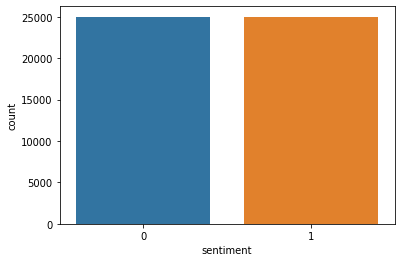

In [10]:
sns.countplot(base_treino['sentiment'], label= 'Contagem')

## Teste

In [33]:
base_teste = pd.read_csv('/content/PNL_Twitter_teste.csv', delimiter=';')

In [34]:
base_teste.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1029536486021099522,@Gazo1a Nossa! Muito obrigada :),Wed Aug 15 01:13:20 +0000 2018,1,:)
1,1029536496368406528,@BerzGamer vai pa puta que te pariu :),Wed Aug 15 01:13:23 +0000 2018,1,:)
2,1029536531655131137,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,Wed Aug 15 01:13:31 +0000 2018,1,:)
3,1029536560117678081,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",Wed Aug 15 01:13:38 +0000 2018,1,:)
4,1029536605852377088,Estávamos em casa do Zé e eu estava a morrer d...,Wed Aug 15 01:13:49 +0000 2018,1,:)


In [35]:
base_teste.shape

(5000, 5)

In [36]:
base_teste.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

#Preprocessamento

- Letras minúsculas
- Nome do usuário (@)
- URLs
- Espaços em branco
- Emoticons
- Stop words
- Lematização
- Pontuações

In [47]:
pln = spacy.load('pt')
pln

In [48]:
stop_words = spacy.lang.pt.stop_words.STOP_WORDS

In [46]:
def preprocessamento(texto):
  # Letras minúsculas
  texto = texto.lower()

  # Nome do usuário
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)

  # URLs
  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)

  # Espaços em branco
  texto = re.sub(r" +", ' ', texto)

  # Emoticons
  lista_emocoes = {':)': 'emocaopositiva',
                   ':d': 'emocaopositiva',
                   ':(': 'emocaonegativa'}
  for emocao in lista_emocoes:
    texto = texto.replace(emocao, lista_emocoes[emocao])

  # Lematização
  documento = pln(texto)

  lista = []
  for token in documento:
    lista.append(token.lemma_)
  
  # Stop words e pontuações
  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  
  return lista

In [50]:
x = preprocessamento("@Laranjito76 A pessoa certa para isso seria o ")
x

'  o pessoa certo parir seriar o'

## Base treino

In [51]:
base_treino['tweet_text'] = base_treino['tweet_text'].apply(preprocessamento)

In [52]:
base_treino.head(10)

,tweet_text,sentiment
0,o pessoa certar parir seriar o valer e azeve...,1
1,parir mim precisamente o contrário emocaopos...,1
2,video hoje ... pensar falar sobrar o meter csg...,1
3,aaaaaaaa amar polaroids expressar o quantum to...,1
4,valorizar o coração menino vc diferente o sorr...,1
5,amigar to emocaopositiva,1
6,bravo jairo emocaopositiva,1
7,socorrer ksoaksosks achar to o caixa som :p,1
8,gostar fazenda emocaopositiva morrer medo ga...,1
9,amanhar venom d,1


## Base Teste

In [53]:
base_teste['tweet_text'] = base_teste['tweet_text'].apply(preprocessamento)
base_teste.head(10)

,tweet_text,sentiment
0,obrigar emocaopositiva,1
1,pa puta parir emocaopositiva,1
2,querer desconto 14/08 ⭐ ⭐ ⭐ ⭐ ⭐ 🌐 conferir o l...,1
3,vcs ajudar galera pelar amor butera emocaoposi...,1
4,casar zé e o morrer sono chegar o casar e fica...,1


In [54]:
# Tratando as classes

base_final = []

for texto, emocao in zip(base_treino['tweet_text'], base_treino['sentiment']):

  if emocao == 1:
    dic = ({'POSITIVO': True, "NEGATIVO": False})

  elif emocao == 0:
    dic = ({'POSITIVO': False, "NEGATIVO": True})

  base_final.append([texto, dic.copy()])

In [55]:
base_final

[['  o pessoa certar parir seriar o valer e azevedo emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['  parir mim precisamente o contrário emocaopositiva o chuva e o disposição emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['video hoje ... pensar falar sobrar o meter csgo e sobrar o paginar alguem umar sugestao querer falar sobrar cenario nacional d',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['aaaaaaaa amar polaroids expressar o quantum to apaixonar vdd ✨ 💖 🎈 🎉 🎊 esperar outro pessoa conseguir ganhar emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['valorizar o coração menino vc diferente o sorrir e d ❤ ️ — valorizar mundo o vidar diferente emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['  amigar to emocaopositiva', {'NEGATIVO': False, 'POSITIVO': True}],
 ['  bravo jairo emocaopositiva', {'NEGATIVO': False, 'POSITIVO': True}],
 ['  socorrer ksoaksosks achar to o caixa som :p',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['  gostar f

# Classificador

In [67]:
modelo = spacy.blank('pt')
categorias = modelo.create_pipe("textcat")
categorias.add_label("POSITIVO")
categorias.add_label("NEGATIVO")
modelo.add_pipe(categorias)
historico = []

In [68]:
modelo.begin_training()
for epoca in range(5):
  random.shuffle(base_final)
  losses = {}

  for batch in spacy.util.minibatch(base_final, 512):
    textos = [modelo(texto) for texto, entities in batch]
    annotations = [{'cats' : entities} for texto, entities in batch]
    modelo.update(textos, annotations, losses = losses)
    historico.append(losses)
  
  if epoca % 5 == 0:
    print(losses)

{'textcat': 5.594762399852016e-05}


In [69]:
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat'))

In [70]:
historico_loss = np.array(historico_loss)

Text(0, 0.5, 'Erro')

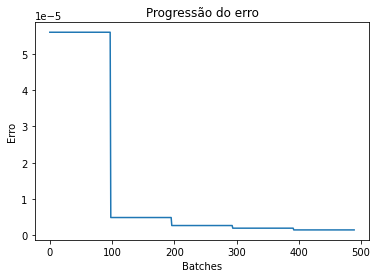

In [71]:
import matplotlib.pyplot as plt
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Batches')
plt.ylabel('Erro')

In [72]:
modelo.to_disk("modelo")

# Testando

In [73]:
modelo_carregado = spacy.load('modelo')
modelo_carregado

In [74]:
texto_positivo = base_teste['tweet_text'][21]
texto_positivo

'  ficar feliz q recíproco emocaopositiva'

In [76]:
previsao = modelo_carregado(texto_positivo)
previsao.cats

{'NEGATIVO': 0.0015245367540046573, 'POSITIVO': 0.9986699819564819}

In [77]:
base_teste['tweet_text'][4000]

'tô triste filmar mulan o mushu emocaonegativa'

In [78]:
texto_negativo = base_teste['tweet_text'][4000]
previsao = modelo_carregado(texto_negativo)
previsao.cats

{'NEGATIVO': 0.9921999573707581, 'POSITIVO': 0.0010575060732662678}

In [79]:
Lusca = preprocessamento('Realmente, essa parte que consta dentro do capítulo número vinte e seis de Hunter X Hunter, é muito pertinente e importante para o desenrolar da história no futuro')
modelo_carregado(Lusca).cats


{'NEGATIVO': 0.020488938316702843, 'POSITIVO': 0.986063539981842}

In [89]:
lusca = preprocessamento('Caralho eu não aguento mais, é sempre uma porcentagem alta e positiva, eu quero ver esse algoritmo na cadeia, é isso que eu quero ver!')
modelo_carregado(lusca).cats

{'NEGATIVO': 0.34112489223480225, 'POSITIVO': 0.8038284778594971}

In [93]:
exemplo1 = preprocessamento('caralho, essa porra desse dia tá um cu de ruim, vou me matar')
modelo_carregado(exemplo1).cats

{'NEGATIVO': 0.22322490811347961, 'POSITIVO': 0.9136261343955994}

# Avaliando o modelo

In [80]:
previsoes = []
for texto in base_teste['tweet_text']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [81]:
previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']:
    previsoes_final.append(1)
  else:
    previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)

In [82]:
respostas_reais = base_teste['sentiment'].values

In [83]:
from sklearn.metrics import accuracy_score
accuracy_score(respostas_reais, previsoes_final)

0.9924

In [84]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

array([[2471,   29],
       [   9, 2491]])

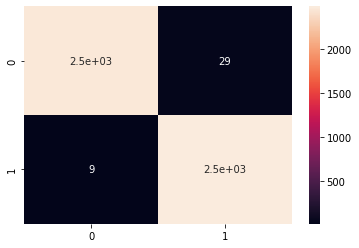

In [85]:
sns.heatmap(cm, annot=True)